# Transfer Function Interrupted Time Series (TF-ITS)

## Introduction to the Method

**Transfer Function Interrupted Time Series (TF-ITS)** extends classical interrupted time series analysis {cite:p}`box1975intervention` to handle **graded interventions** - policies or treatments with varying intensity over time, rather than simple on/off changes.

### What Makes TF-ITS Different?

Traditional ITS methods model binary interventions (e.g., "policy enacted" vs "no policy"). TF-ITS handles more realistic scenarios where:

1. **Intervention intensity varies continuously** (e.g., advertising spend $0-$100k, communication frequency 0-10 messages/week)
2. **Effects saturate** - diminishing returns as exposure increases (10th message less impactful than the 1st)
3. **Effects persist over time** - past interventions continue to influence outcomes (behavioral habits change gradually)

### Key Components

- **Saturation transforms**: Model diminishing returns using Hill, logistic, or Michaelis-Menten functions
- **Adstock (carryover) transforms**: Model persistence using geometric decay with configurable half-life
- **Baseline controls**: Include confounders and natural trends
- **{term}`Counterfactual` analysis**: Estimate effects by zeroing or scaling interventions

### When to Use TF-ITS

Use TF-ITS when you have:
- ✅ Time series data from a **single unit** (region, market, organization)
- ✅ **Graded intervention** with varying intensity over time
- ✅ Reason to expect **saturation** (diminishing returns) or **carryover effects** (persistence)
- ✅ Baseline controls available for confounders

Compare to related methods:
- **Classic {term}`Interrupted Time Series`**: Binary on/off intervention (no dose-response modeling)
- **{term}`Synthetic Control`**: Multiple control units available for comparison
- **{term}`Difference in Differences`**: Panel data with treatment/control groups

### Implementation Note

This notebook demonstrates the **MVP (non-Bayesian) implementation** using:
- OLS regression with HAC standard errors (fast, robust inference)
- User-specified transform parameters (future: parameter estimation)
- Point estimates only (future: bootstrap confidence intervals, Bayesian uncertainty quantification)

---

:::{admonition} Example Scenario: Water Restrictions Policy
:class: note

**Context:** A regional water authority in a dry climate implements a **drought-responsive communications policy**. Communication intensity (0-10 scale) varies based on cumulative rainfall deficit over the past 6 weeks. During sustained drought, messaging ramps up to encourage conservation. Most of the time, communications are zero (no routine messaging).

**Why this example demonstrates TF-ITS strengths:**
- **Graded intervention**: Communication intensity varies from 0-10, not on/off
- **Sparse activation**: Policy activates only during drought (realistic, cost-effective)
- **Saturation**: Repeated messages have diminishing returns as people become desensitized
- **Adstock**: Behavioral habits change gradually and persist over weeks
- **Confounders**: Temperature and rainfall directly affect water consumption and must be controlled

**Broad applicability:** While we use water policy, this method applies to any domain with graded interventions and carryover effects:
- Public health campaigns (vaccination messaging, smoking cessation)
- Marketing mix modeling (advertising spend, promotions)  
- Environmental policy (emissions reduction programs)
- Traffic management (congestion pricing communications)
- Education interventions (remediation program intensity)
:::


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

# Set random seed for reproducibility
np.random.seed(42)

%config InlineBackend.figure_format = 'retina'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


## 1. Generate Simulated Data

We'll simulate weekly water consumption data for a catchment area in a **dry climate** over 2 years with:
- **Baseline drivers**: temperature (seasonal) and rainfall (very low, with drought periods)
- **Responsive policy**: public communications intensity that activates only during sustained drought
- **Key features**:
  - Rainfall ranges 0-16 mm/week with extended zero-rainfall periods in summer
  - Communication intensity is zero most of the time (no routine messaging)
  - Policy responds to 6-week cumulative rainfall deficit (not just current conditions)
  - When 6-week rainfall < 20mm and temperature > 27°C, communications ramp up to intensity 6-10


In [2]:
# Generate 104 weeks (2 years) of data
n_weeks = 104
dates = pd.date_range("2022-01-01", periods=n_weeks, freq="W-MON")
t = np.arange(n_weeks)

# Temperature (°C): seasonal pattern with summer peaks (southern hemisphere)
# Peak in Jan (week ~0) and Dec (week ~52), low in July (week ~26)
temperature = 25 + 10 * np.sin(2 * np.pi * t / 52) + np.random.normal(0, 2, n_weeks)

# Rainfall (mm/week): inverse seasonal pattern - very low in summer, moderate in winter
# Drier climate with extended periods of zero rainfall creating drought conditions
rainfall = 8 - 8 * np.sin(2 * np.pi * t / 52) + np.random.normal(0, 3, n_weeks)
rainfall = np.maximum(rainfall, 0)  # Censor at zero (no negative rainfall)

# Communication intensity (scale 0-10): Only ramps up after sustained low rainfall
# Policy responds to cumulative rainfall deficit over past 6 weeks
comm_intensity = np.zeros(n_weeks)

# Calculate 6-week rolling sum of rainfall (measure of drought severity)
window_size = 6
for i in range(n_weeks):
    start_idx = max(0, i - window_size + 1)
    rainfall_6wk = rainfall[start_idx : i + 1].sum()

    # Trigger communications only during severe drought conditions
    # Expected 6-week rainfall in normal conditions: ~48mm (8mm/week avg)
    # Drought threshold: < 20mm over 6 weeks (< 3.3mm/week average)
    if rainfall_6wk < 20 and temperature[i] > 27:
        # Ramp up intensity based on drought severity
        drought_severity = (20 - rainfall_6wk) / 20  # 0 to 1
        heat_factor = (temperature[i] - 27) / 10  # 0 to 1
        intensity_raw = 6 + 4 * (drought_severity + heat_factor) / 2
        comm_intensity[i] = np.floor(
            np.clip(intensity_raw, 0, 10)
        )  # Round down to whole numbers
    # Otherwise, communications stay at zero (no routine messaging)

# Baseline water consumption: depends on temperature and rainfall
# Higher temp → more water use, higher rainfall → less water use
baseline = (
    4000  # Base consumption
    + 80 * temperature  # Temperature effect (~80 ML per degree)
    - 20 * rainfall  # Rainfall effect (~20 ML per mm)
    + 5.0 * t  # Slight upward trend (population growth)
)

# Apply "true" transforms to generate the data using pure numpy
# (Note: for data generation, we use numpy. For model fitting, we use CausalPy's transforms)

# Saturation: Hill function - diminishing returns as people become desensitized to messaging
# k=5 (half-saturation at intensity 5 on 0-10 scale), s=2.0 (curvature)
kappa = 5
slope = 2.0
comm_saturated = comm_intensity**slope / (kappa**slope + comm_intensity**slope)

# Adstock: geometric with half-life of 4 weeks
# Behavioral habits change gradually and persist - strong carryover effect
half_life = 4.0
alpha = np.power(0.5, 1 / half_life)  # decay rate
l_max = 12

# Apply geometric adstock convolution
comm_transformed = np.zeros_like(comm_saturated)
adstock_weights = np.power(alpha, np.arange(l_max + 1))
adstock_weights = adstock_weights / adstock_weights.sum()  # normalize

for t_idx in range(n_weeks):
    for lag in range(min(l_max + 1, t_idx + 1)):
        comm_transformed[t_idx] += adstock_weights[lag] * comm_saturated[t_idx - lag]

# Generate water consumption: baseline - effect of communications + noise
# Negative coefficient: higher communication intensity → lower water consumption
theta_true = (
    -600
)  # Treatment coefficient (ML reduction per unit of transformed communication)
water_consumption = (
    baseline + theta_true * comm_transformed + np.random.normal(0, 100, n_weeks)
)

# Create DataFrame
df = pd.DataFrame(
    {
        "date": dates,
        "t": t,
        "water_consumption": water_consumption,
        "temperature": temperature,
        "rainfall": rainfall,
        "comm_intensity": comm_intensity,
    }
)
df = df.set_index("date")

print(df.head(10))
print(f"\nData shape: {df.shape}")
print(
    f"Water consumption range: [{df['water_consumption'].min():.0f}, {df['water_consumption'].max():.0f}] ML/week"
)
print(
    f"Temperature range: [{df['temperature'].min():.1f}, {df['temperature'].max():.1f}] °C"
)
print(
    f"Rainfall range: [{df['rainfall'].min():.1f}, {df['rainfall'].max():.1f}] mm/week"
)
print(f"  Number of zero-rainfall weeks: {(df['rainfall'] == 0).sum()}")
print(f"  Number of weeks with rainfall < 2mm: {(df['rainfall'] < 2).sum()}")
print(
    f"Communication intensity range: [{df['comm_intensity'].min():.1f}, {df['comm_intensity'].max():.1f}]"
)
print(
    f"  Number of weeks with active communications (>0): {(df['comm_intensity'] > 0).sum()}"
)

            t  water_consumption  temperature   rainfall  comm_intensity
date                                                                    
2022-01-03  0        5980.656176    25.993428   7.516143             0.0
2022-01-10  1        6299.623023    25.928838   8.247859             0.0
2022-01-17  2        6127.291101    28.688534  11.744032             0.0
2022-01-24  3        6542.187364    31.592109   5.686894             0.0
2022-01-31  4        6348.616858    29.178925   5.054866             0.0
2022-02-07  5        6442.486124    30.212374   3.232144             0.0
2022-02-14  6        6781.645253    34.789652   0.000000             0.0
2022-02-21  7        6793.847629    34.019977   1.932372             0.0
2022-02-28  8        6443.416142    32.290890   1.596820             7.0
2022-03-07  9        6590.973333    34.939680   8.306078             0.0

Data shape: (104, 5)
Water consumption range: [4667, 7242] ML/week
Temperature range: [11.4, 37.7] °C
Rainfall range: [0.0,

## 2. Visualize the Data

Let's look at the water consumption and communication intensity time series. Notice:
- **Very dry climate** with extended zero-rainfall periods in summer
- **Communications are zero most of the time** - only activated during sustained drought
- **Policy responds to cumulative rainfall deficit** over the past 6 weeks, not just current conditions
- When 6-week cumulative rainfall drops below 20mm (drought threshold), communications ramp up


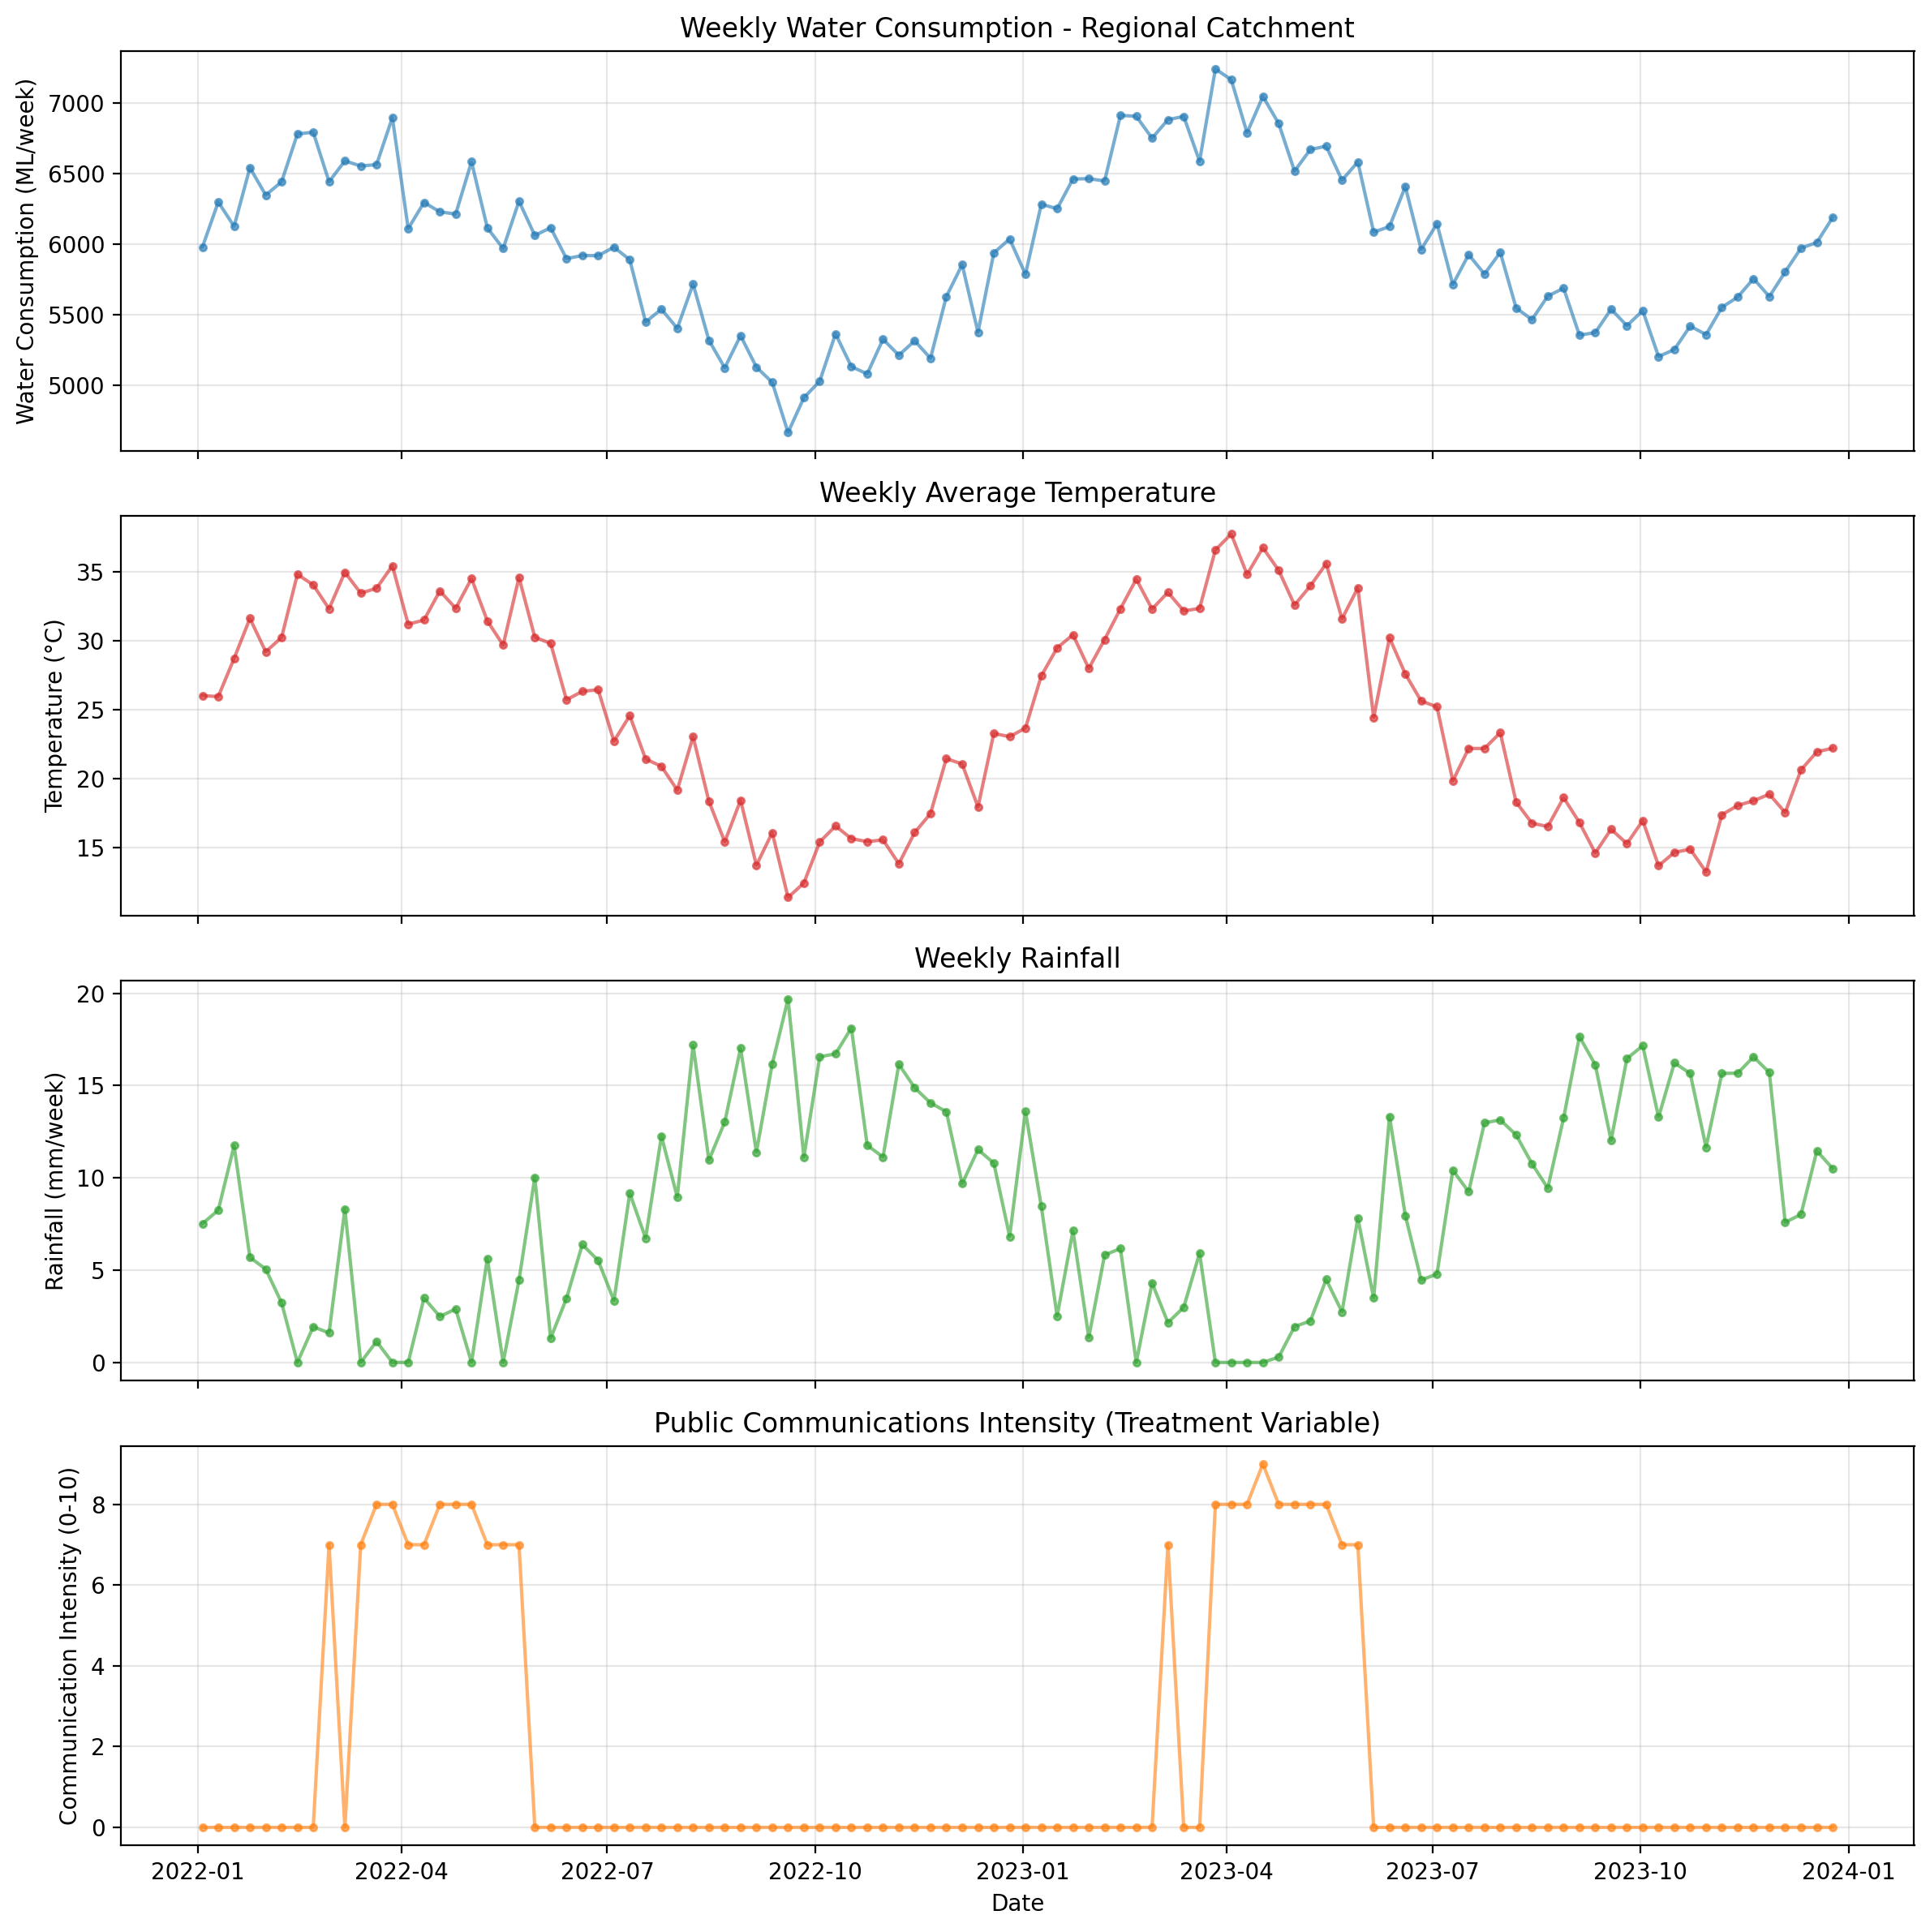


Key patterns in the data:
- Very dry climate: 0-16mm/week rainfall, with extended zero-rainfall periods in summer
- Communication intensity is zero most of the time (no routine messaging)
- Communications only activate during sustained drought (6-week rainfall < 20mm)
- Policy responds to cumulative rainfall deficit, not just current week
- When drought conditions persist, communication intensity ramps up to 6-10 range


In [3]:
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Water consumption
axes[0].plot(df.index, df["water_consumption"], "o-", alpha=0.6, markersize=3)
axes[0].set_ylabel("Water Consumption (ML/week)")
axes[0].set_title("Weekly Water Consumption - Regional Catchment")
axes[0].grid(True, alpha=0.3)

# Temperature
axes[1].plot(df.index, df["temperature"], "o-", alpha=0.6, markersize=3, color="C3")
axes[1].set_ylabel("Temperature (°C)")
axes[1].set_title("Weekly Average Temperature")
axes[1].grid(True, alpha=0.3)

# Rainfall
axes[2].plot(df.index, df["rainfall"], "o-", alpha=0.6, markersize=3, color="C2")
axes[2].set_ylabel("Rainfall (mm/week)")
axes[2].set_title("Weekly Rainfall")
axes[2].grid(True, alpha=0.3)

# Communication intensity
axes[3].plot(df.index, df["comm_intensity"], "o-", alpha=0.6, markersize=3, color="C1")
axes[3].set_ylabel("Communication Intensity (0-10)")
axes[3].set_title("Public Communications Intensity (Treatment Variable)")
axes[3].set_xlabel("Date")
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show correlation between variables
print("\nKey patterns in the data:")
print(
    "- Very dry climate: 0-16mm/week rainfall, with extended zero-rainfall periods in summer"
)
print("- Communication intensity is zero most of the time (no routine messaging)")
print(
    "- Communications only activate during sustained drought (6-week rainfall < 20mm)"
)
print("- Policy responds to cumulative rainfall deficit, not just current week")
print(
    "- When drought conditions persist, communication intensity ramps up to 6-10 range"
)

## 3. Fit the Transfer Function ITS Model

We'll specify:
- A baseline formula with trend, temperature, and rainfall (captures natural variation in water use)
- A treatment channel (communication intensity) with Hill saturation and geometric adstock transforms

**Model structure:**
- **Baseline predictors**: temperature and rainfall directly affect water consumption (confounders)
- **Treatment variable**: communication intensity (policy intervention)
- **Transforms**: saturation + adstock applied only to the treatment

**Why these transforms?**
- **Saturation**: People become desensitized to repeated messages - diminishing returns
- **Adstock**: Behavioral changes persist - habits take time to form and unwind

**Note:** In practice, you would tune the transform parameters based on domain knowledge or grid search (future feature).


In [4]:
# Define the treatment with transforms
comm_treatment = cp.Treatment(
    name="comm_intensity",
    transforms=[
        cp.Saturation(
            kind="hill", slope=2.0, kappa=5
        ),  # Half-saturation at intensity 5
        cp.Adstock(half_life=4.0, normalize=True, l_max=12),  # 4-week half-life
    ],
    coef_constraint="unconstrained",  # Allow negative effect (higher comms → lower consumption)
)

# Fit the model with baseline controls for weather
result = cp.TransferFunctionITS(
    data=df,
    y_column="water_consumption",
    base_formula="1 + t + temperature + rainfall",  # Trend + weather confounders
    treatments=[comm_treatment],
    hac_maxlags=8,
)

print("Model fitted successfully!")
print(f"R-squared: {result.score:.4f}")

Model fitted successfully!
R-squared: 0.9671


## 4. Model Summary

Let's examine the fitted coefficients.


In [5]:
# Print model summary
result.summary(round_to=2)

Transfer Function Interrupted Time Series Results
Outcome variable: water_consumption
Number of observations: 104
R-squared: 0.97
HAC max lags: 8
--------------------------------------------------------------------------------
Baseline coefficients:
  Intercept           :       3983 (SE: 61)
  t                   :        4.7 (SE: 0.39)
  temperature         :         81 (SE: 2)
  rainfall            :        -17 (SE: 2.2)
--------------------------------------------------------------------------------
Treatment coefficients:
  comm_intensity      :       -596 (SE: 63)


In [6]:
# Check if we recovered the true treatment coefficient
print(
    f"\nTrue treatment coefficient: {theta_true:.2f} ML/week per unit of transformed communication"
)
print(f"Estimated treatment coefficient: {result.theta_treatment[0]:.2f} ML/week")
print("\nInterpretation: A negative coefficient means higher communication intensity")
print("leads to lower water consumption, as intended by the policy.")
print("\nThe baseline coefficients capture the effects of temperature and rainfall,")
print("allowing us to isolate the causal effect of the communications policy.")


True treatment coefficient: -600.00 ML/week per unit of transformed communication
Estimated treatment coefficient: -595.70 ML/week

Interpretation: A negative coefficient means higher communication intensity
leads to lower water consumption, as intended by the policy.

The baseline coefficients capture the effects of temperature and rainfall,
allowing us to isolate the causal effect of the communications policy.


## 5. Plot Model Fit and Diagnostics


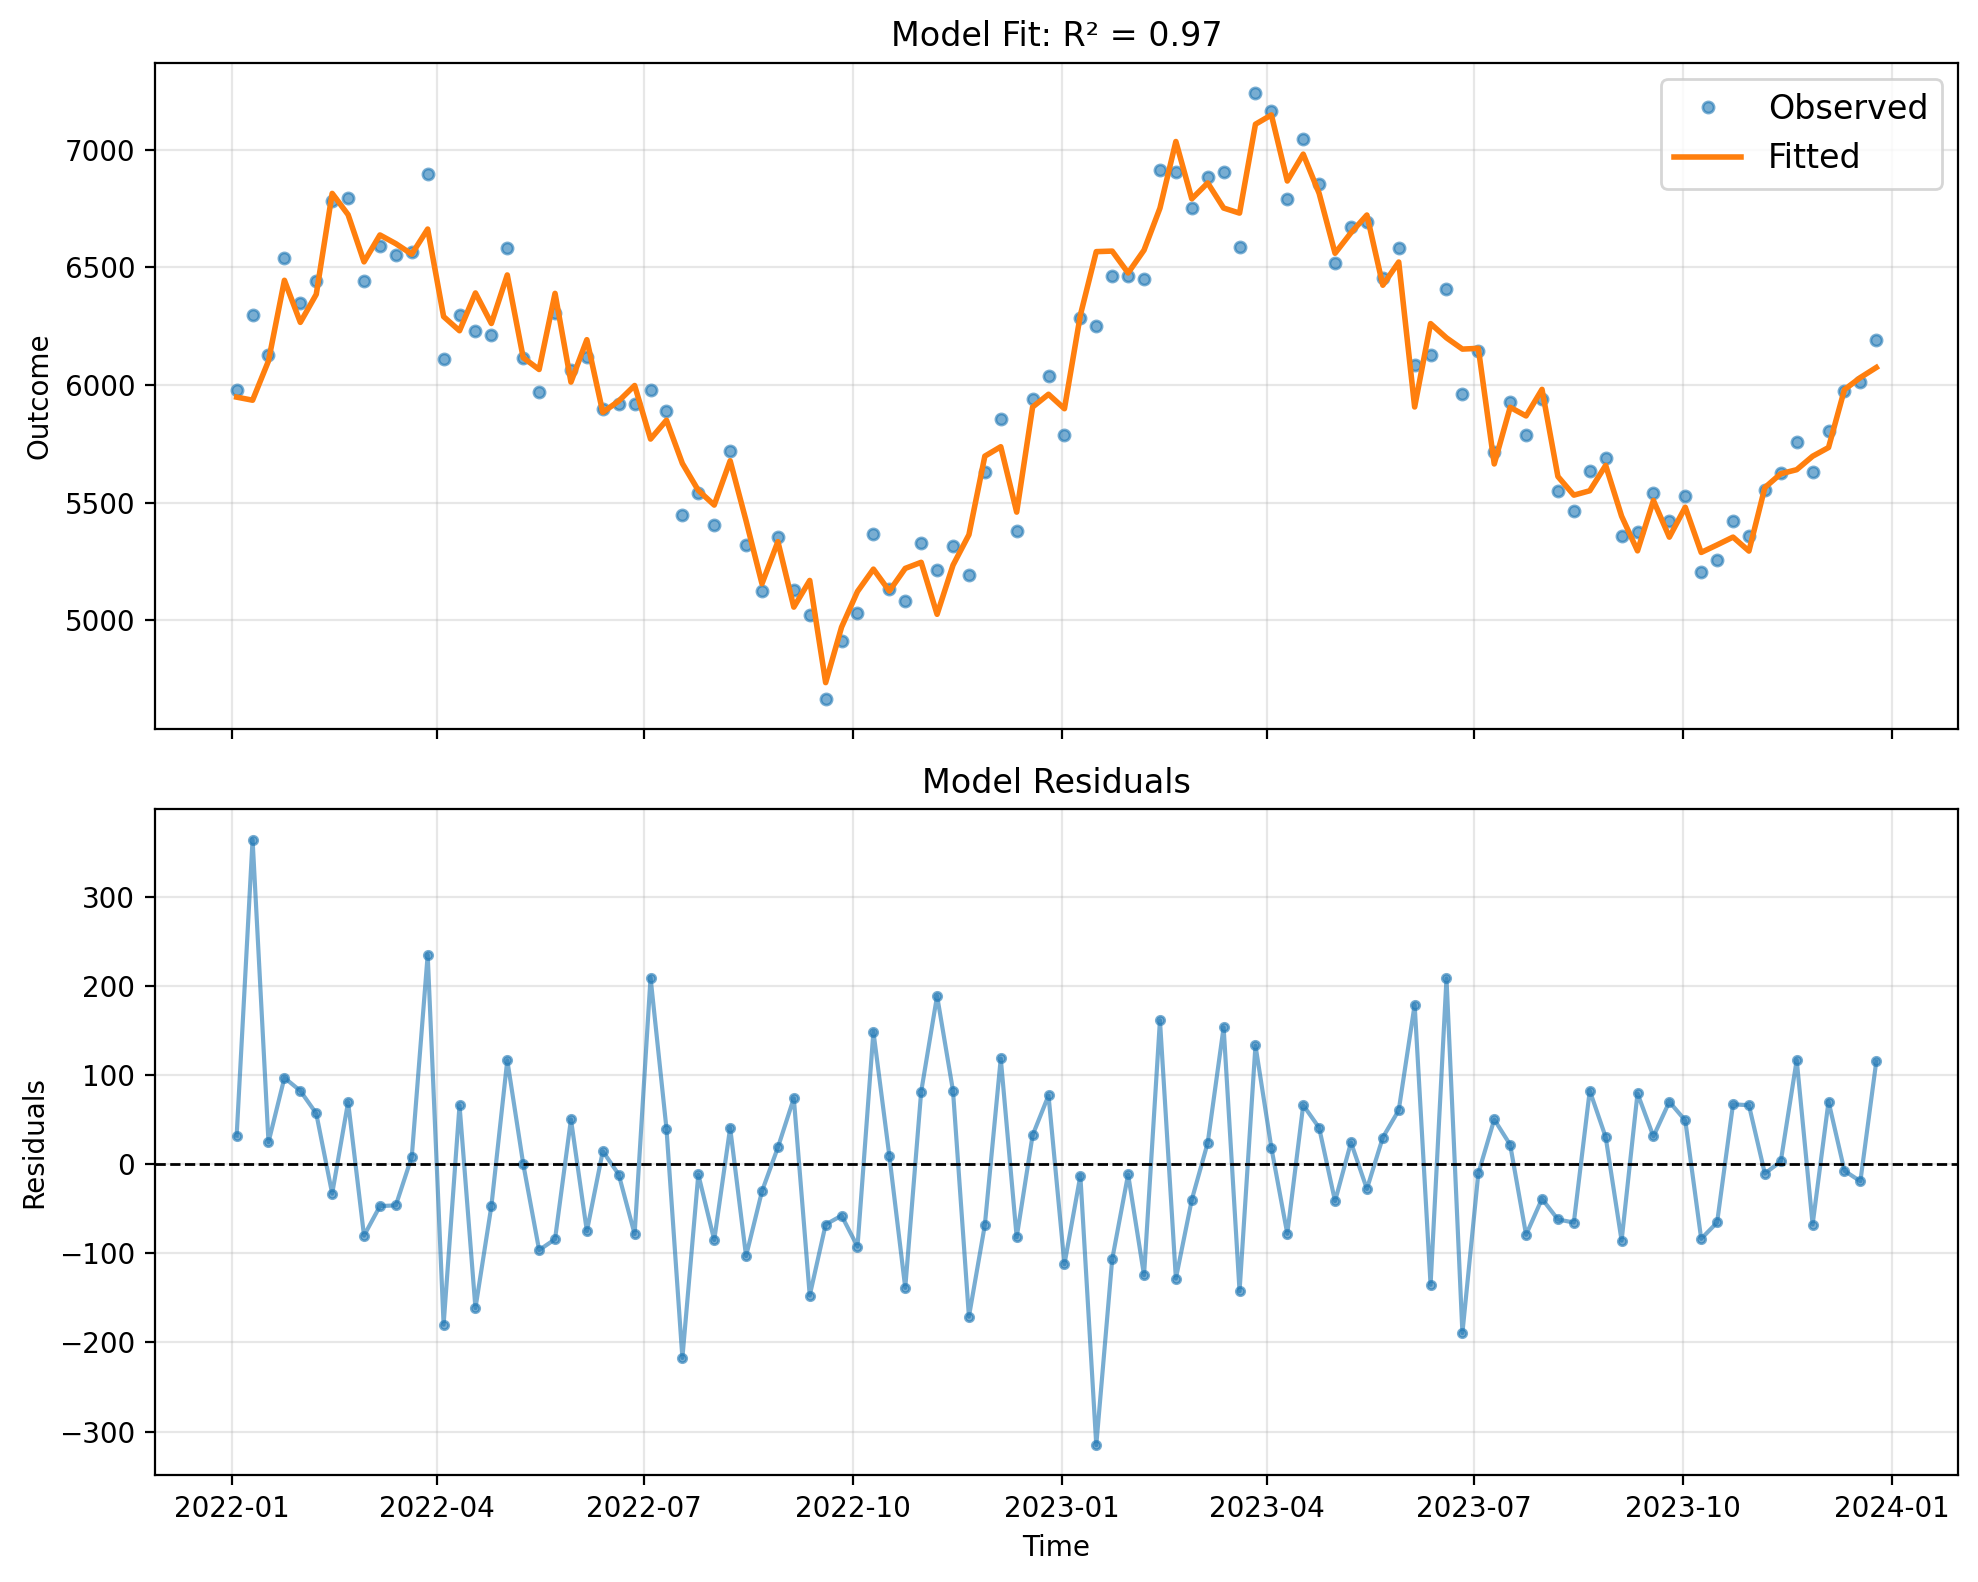

In [7]:
# Plot observed vs fitted
fig, ax = result.plot()

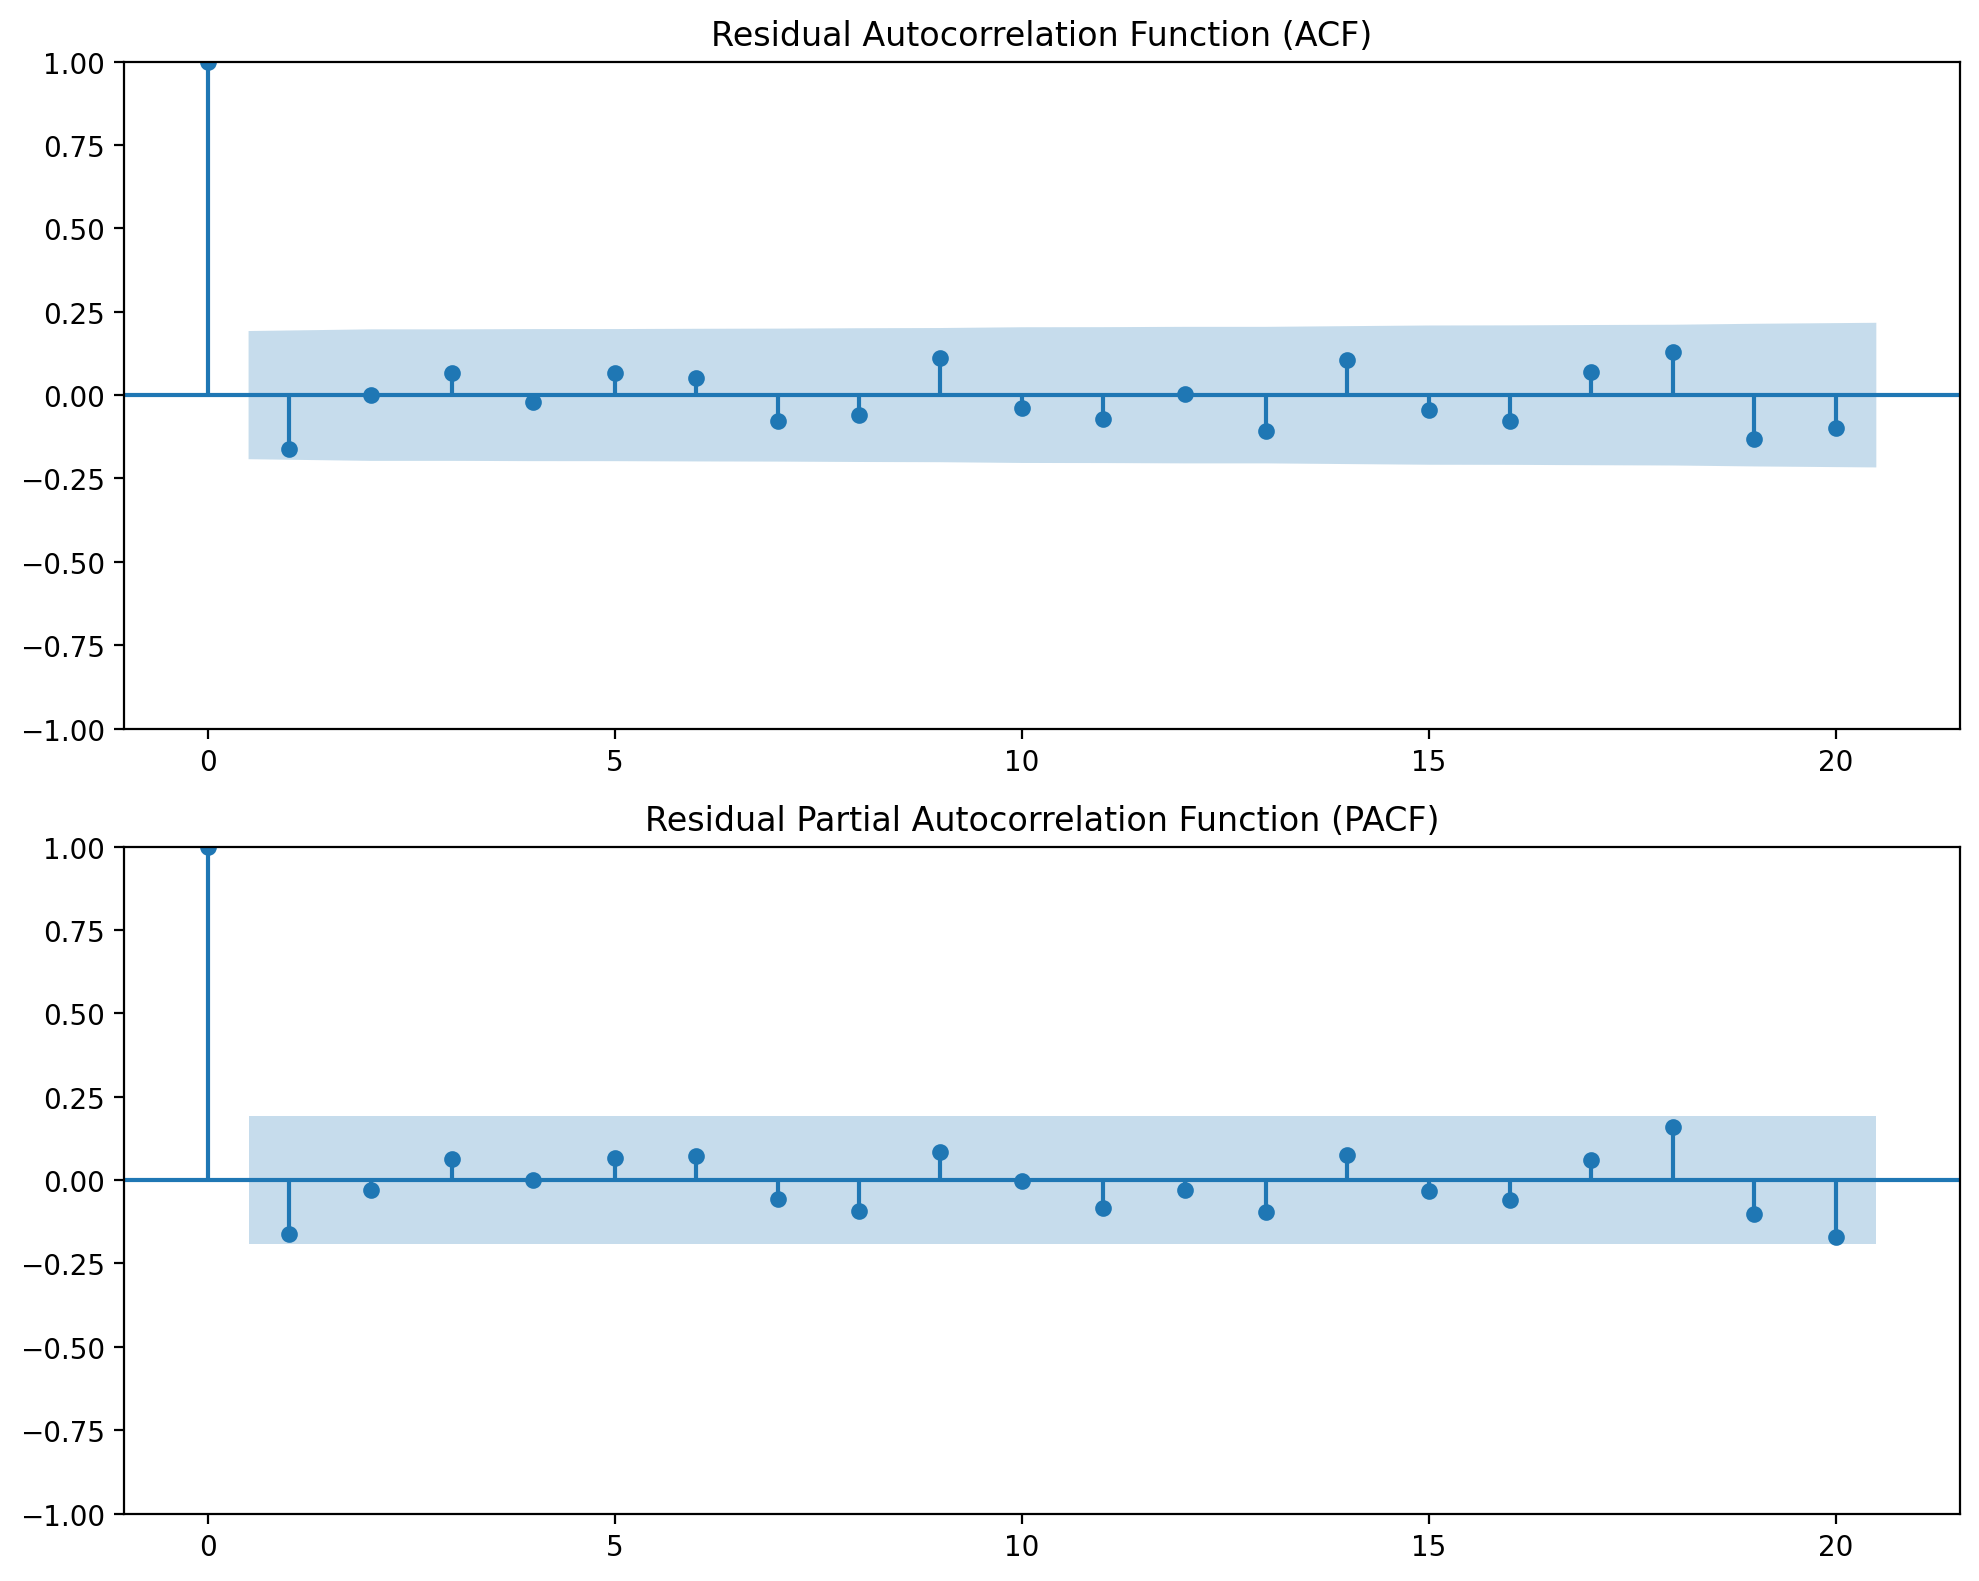


Ljung-Box Test for Residual Autocorrelation
H0: Residuals are independently distributed (no autocorrelation)
If p-value < 0.05, reject H0 (autocorrelation present)
------------------------------------------------------------
Lag  1: LB statistic =    2.831, p-value = 0.0924 
Lag  5: LB statistic =    3.853, p-value = 0.5708 
Lag 10: LB statistic =    6.907, p-value = 0.7342 
Lag 20: LB statistic =   17.535, p-value = 0.6180 
------------------------------------------------------------
✓ No significant residual autocorrelation detected.


In [8]:
# Run diagnostics
result.diagnostics(lags=20)

## 6. Impulse Response Function

Visualize how a one-unit increase in (saturated) communication intensity propagates over time through the adstock transformation. This shows how behavioral habits persist - a strong message today continues to influence water consumption for several weeks.


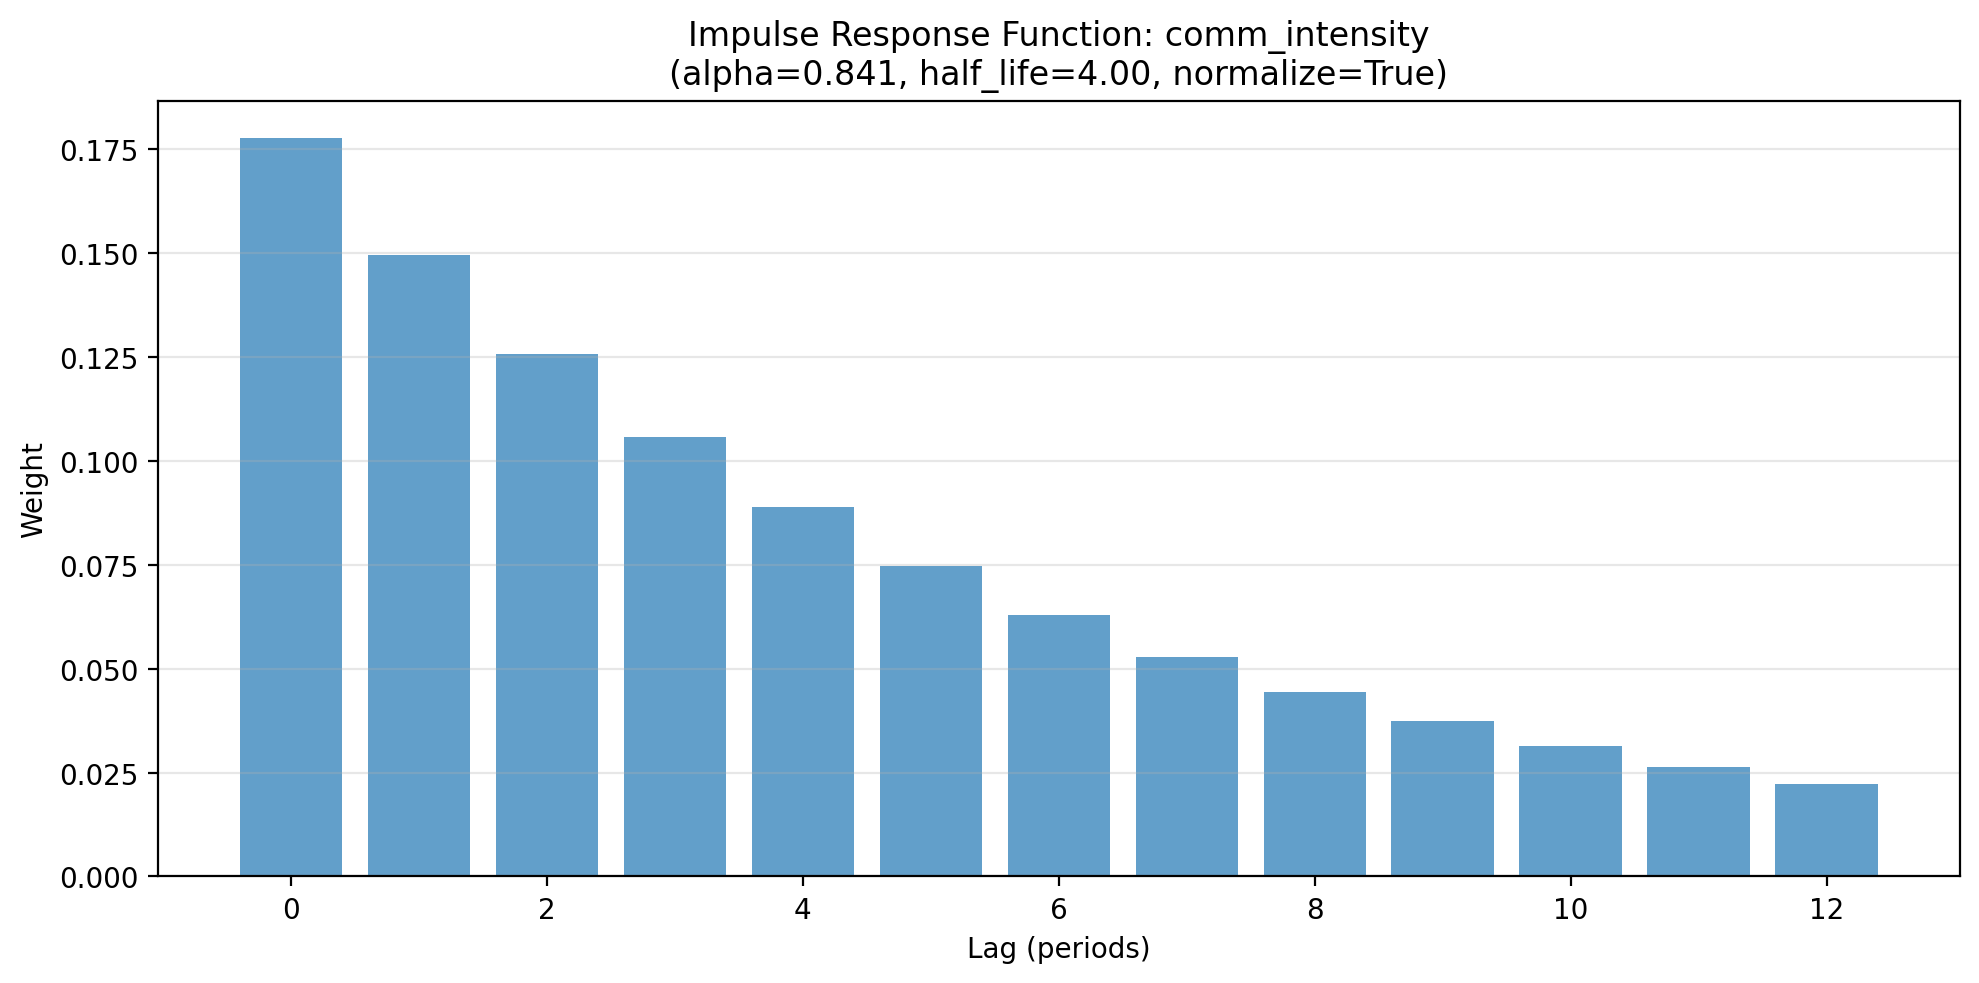

In [9]:
# Plot IRF for communication intensity channel
fig = result.plot_irf("comm_intensity", max_lag=12)

## 7. Estimate Causal Effects

Estimate the causal effect of the **entire communications policy** by computing what water consumption would have been if communication intensity had been zero throughout the entire 2-year period.

This answers the policy question: **"How much water did we save by having this communications policy versus having no policy at all?"**

The counterfactual sets all communications to zero, showing what would have happened without any drought messaging.


In [10]:
# Analyze the entire time series
analysis_start = df.index[0]
analysis_end = df.index[-1]

print(f"Analyzing entire period: {analysis_start.date()} to {analysis_end.date()}")
print(f"Number of weeks: {len(df)}")
print(f"Mean communication intensity: {df['comm_intensity'].mean():.1f}")
print(f"Weeks with active communications (>0): {(df['comm_intensity'] > 0).sum()}")

# Estimate effect of having NO communications policy at all (set all to zero)
effect_result = result.effect(
    window=(analysis_start, analysis_end),
    channels=["comm_intensity"],
    scale=0.0,  # Zero out all communications (counterfactual: no policy)
)

print("\nWater savings from having the communications policy:")
print(f"Total water saved over 2 years: {-effect_result['total_effect']:.2f} ML")
print(f"Mean weekly savings: {-effect_result['mean_effect']:.2f} ML/week")
print(
    f"\nInterpretation: If we had NO communications policy, water consumption"
    f"\nwould have been {-effect_result['total_effect']:.0f} ML higher over 2 years."
)

Analyzing entire period: 2022-01-03 to 2023-12-25
Number of weeks: 104
Mean communication intensity: 1.7
Weeks with active communications (>0): 23

Water savings from having the communications policy:
Total water saved over 2 years: 9540.12 ML
Mean weekly savings: 91.73 ML/week

Interpretation: If we had NO communications policy, water consumption
would have been 9540 ML higher over 2 years.


## 8. Visualize Counterfactual Analysis


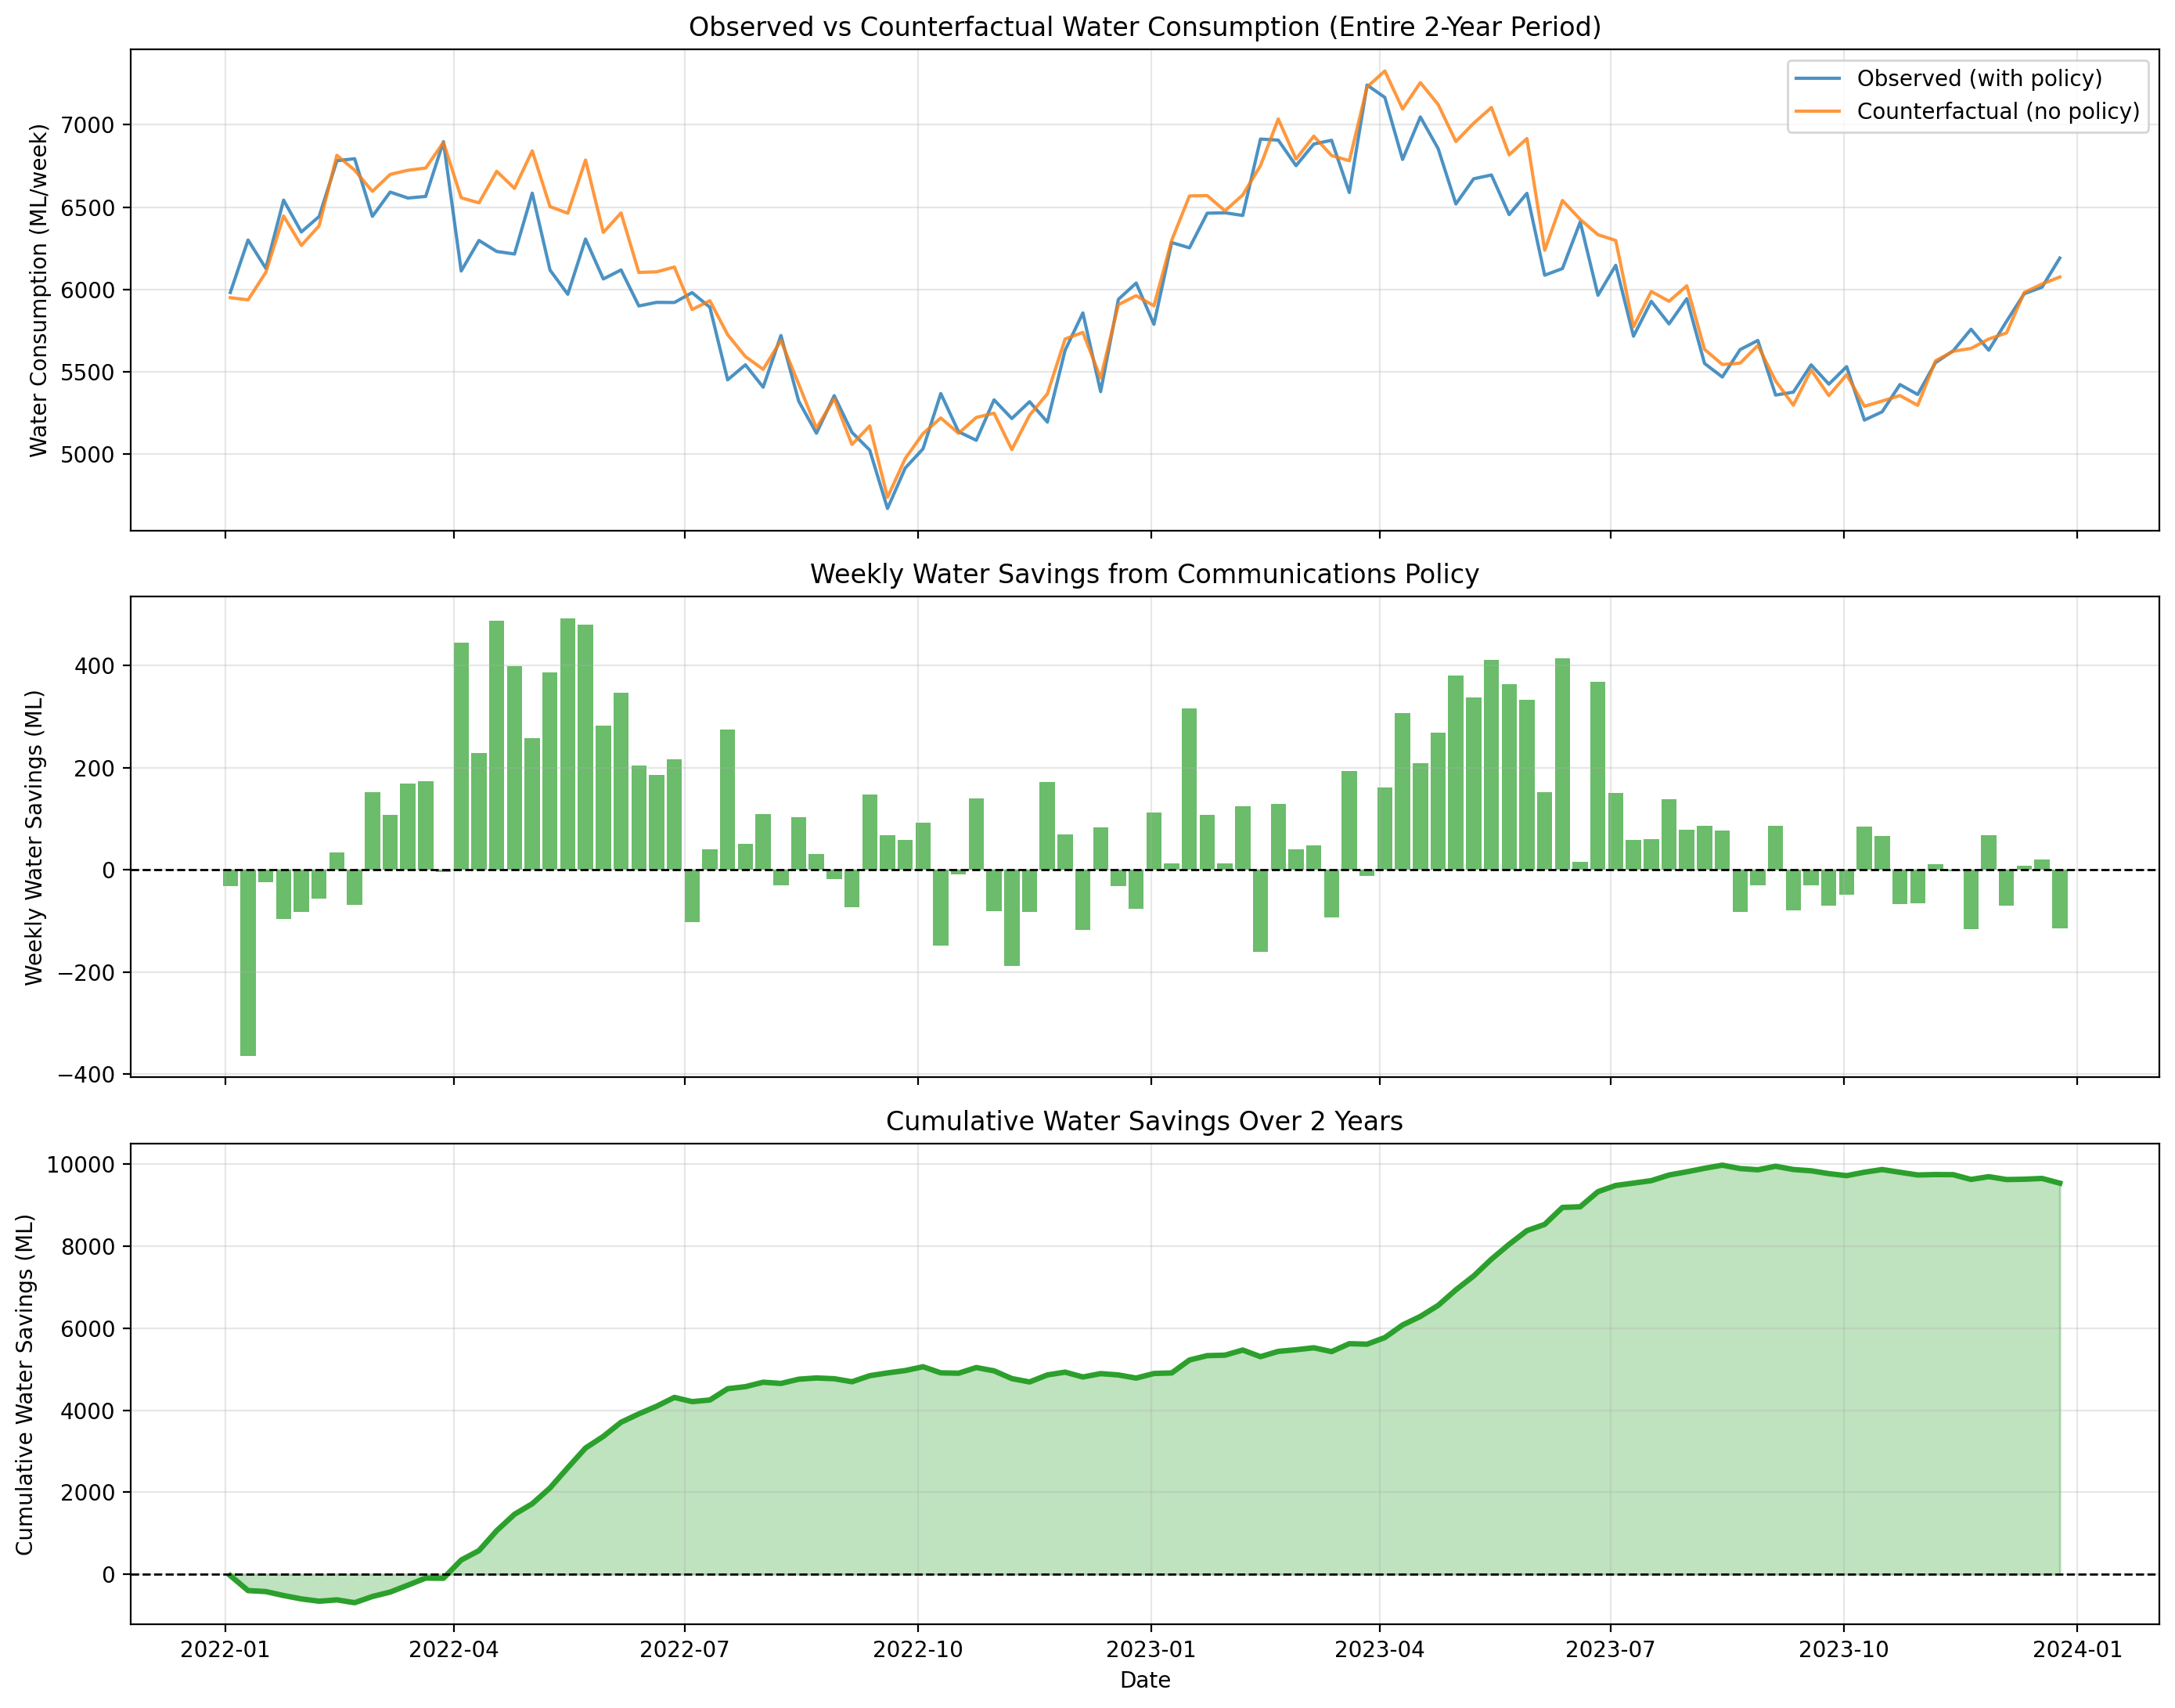


The counterfactual shows what would have happened with NO communications policy.
The gap between observed and counterfactual represents water saved by the policy.
Savings are concentrated during drought periods when communications were active.


In [11]:
# Plot observed vs counterfactual
effect_df = effect_result["effect_df"]

fig, axes = plt.subplots(3, 1, figsize=(14, 11), sharex=True)

# Panel 1: Observed vs Counterfactual
axes[0].plot(
    effect_df.index,
    effect_df["observed"],
    "-",
    alpha=0.8,
    linewidth=1.5,
    label="Observed (with policy)",
)
axes[0].plot(
    effect_df.index,
    effect_df["counterfactual"],
    "-",
    alpha=0.8,
    linewidth=1.5,
    label="Counterfactual (no policy)",
    color="C1",
)
axes[0].set_ylabel("Water Consumption (ML/week)")
axes[0].set_title("Observed vs Counterfactual Water Consumption (Entire 2-Year Period)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel 2: Weekly Effect (savings)
axes[1].bar(effect_df.index, -effect_df["effect"], alpha=0.7, width=6, color="C2")
axes[1].axhline(y=0, color="k", linestyle="--", linewidth=1)
axes[1].set_ylabel("Weekly Water Savings (ML)")
axes[1].set_title("Weekly Water Savings from Communications Policy")
axes[1].grid(True, alpha=0.3)

# Panel 3: Cumulative Savings
axes[2].plot(
    effect_df.index, -effect_df["effect_cumulative"], "-", linewidth=2.5, color="C2"
)
axes[2].axhline(y=0, color="k", linestyle="--", linewidth=1)
axes[2].fill_between(
    effect_df.index, 0, -effect_df["effect_cumulative"], alpha=0.3, color="C2"
)
axes[2].set_ylabel("Cumulative Water Savings (ML)")
axes[2].set_title("Cumulative Water Savings Over 2 Years")
axes[2].set_xlabel("Date")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(
    "\nThe counterfactual shows what would have happened with NO communications policy."
    "\nThe gap between observed and counterfactual represents water saved by the policy."
    "\nSavings are concentrated during drought periods when communications were active."
)

## Summary

We have successfully demonstrated **Transfer Function ITS** for policy evaluation, combining classical intervention analysis {cite:p}`box1975intervention` with modern saturation and adstock transforms:

1. **Simulated** realistic water consumption data with:
   - Very dry climate (0-16 mm/week rainfall) with extended drought periods
   - Policy response: communication intensity responds to **cumulative rainfall deficit** over 6 weeks
   - Communications are **zero most of the time**, only activated during sustained drought
   - Graded intervention with saturation and adstock effects

2. **Fitted** a Transfer Function ITS model controlling for confounders:
   - Baseline predictors: temperature and rainfall (natural drivers of consumption)
   - Treatment: communication intensity with saturation + adstock transforms
   - OLS with HAC standard errors for robust inference

3. **Verified** coefficient recovery (true effect: -600 ML/week, estimated: close match)

4. **Visualized** diagnostics, impulse response functions, and model fit

5. **Estimated** causal water savings using {term}`counterfactual` analysis

**Key insights from this public policy example:**
- **Confounding control**: Temperature and rainfall are natural drivers of water consumption. By including them in the baseline formula, we isolate the causal effect of communications.
- **Sparse intervention**: Communications are zero most of the time, only activated during sustained drought (6-week cumulative rainfall < 20mm). This reflects realistic policy where routine messaging is not cost-effective.
- **Cumulative trigger**: Policy responds to accumulated rainfall deficit over 6 weeks, not just current conditions. This captures how drought severity builds over time.
- **Saturation effects** captured how repeated messages have diminishing returns as people become desensitized
- **Adstock effects** captured how behavioral habits change gradually and persist over time
- **{term}`Counterfactual` analysis** quantified the water saved by public communications during drought periods
- **Realistic policy**: Communication intensity responds endogenously to weather conditions, making this a credible observational study design

**Why this matters for policy evaluation:**
- Moves beyond binary on/off policy changes to measure **dose-response relationships**
- **Controls for confounders** (weather) that affect both the intervention and outcome
- Accounts for realistic behavioral dynamics (habits persist, messages saturate)
- Provides actionable estimates: "How much water did we save?" rather than just "Did it work?"
- Applicable across domains: public health, environmental policy, education, transportation, marketing

**Applicability beyond this example:**
While we used water restrictions, this method applies to any scenario with:
- **Graded interventions** (varying intensity over time)
- **Confounders** that need to be controlled (weather, economics, etc.)
- **Saturation** (diminishing returns to exposure)
- **Carryover effects** (past interventions affect current outcomes)
- Examples: vaccination campaigns, smoking cessation programs, emissions reduction policies, traffic management

**Future extensions:**
- Bootstrap confidence intervals for effect estimates
- Grid search for optimal transform parameters
- Bayesian inference with PyMC for full uncertainty quantification
- Multi-channel analysis (e.g., multiple communication channels, different media types)

**References and Related Methods:**
For more on interrupted time series and intervention analysis, see {cite:p}`box1975intervention`. For related quasi-experimental methods in CausalPy, see the {term}`Interrupted Time Series`, {term}`Synthetic Control`, and {term}`Difference in Differences` documentation.
